### Testing video analysis

In [122]:
import datetime
import time
import os

import ffmpeg
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import trace_analysis
import loader

Pipeline

1. get video start and end times

1. get trial times

1. plot video times vs trial times (rag plots)

1. pull video frames for 1 trial


In [103]:
testid = 'Ring_19700101_0000_7260278537587707614.mp4'
id = testid.strip('.mp4').split('_')[-1]
print(len(id))
while len(id) < 19:
    id = id + '0'
# first 32 bits represent seconds since epoch start
starttime = int(id) >> 32
print(starttime)
print(datetime.datetime.fromtimestamp(starttime))

test2 = 'Ring_19700101_0000_7260279293501951710.mp4'
id = test2.strip('.mp4').split('_')[-1]
print(len(id))
# first 32 bits represent seconds since epoch start
starttime = int(id) >> 32
print(starttime)
print(datetime.datetime.fromtimestamp(starttime))


video_path = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\video_data\\OMV4 Dream psAcc48SAT24\\Ring_19700101_0000_7260278537587707614.mp4'
metadata = ffmpeg.probe(video_path)
duration = metadata['format']['duration']
print(duration)
datetime.timedelta(seconds=float(duration))

18
1690415325
2023-07-26 19:48:45
19
1690415501
2023-07-26 19:51:41
69.795000


datetime.timedelta(seconds=69, microseconds=795000)

#### Functions to get video start time and duration

In [104]:
def starttime_from_filename(filename):
# Extracts recording time of Ring videos from filename
# Only works if Ring videos are named in this format: 
# Ring_xxxxxxxxx_xxxx_xxxxxxxxxxxxxxxxxxx.mp4
    id = filename.strip('.mp4').split('_')[-1]
    # Ring filenames drop trailing 0s 
    # (id needs to have exactly 19 digits)
    while len(id) < 19:
        id = id + '0'
    # first 32 bits represent seconds since epoch start
    starttime = int(id) >> 32
    return datetime.datetime.fromtimestamp(starttime)

def duration_from_metadata(filepath):
# Extracts duration of videos from stored metadata
# requires full path, not just file name
    metadata = ffmpeg.probe(filepath)
    duration = metadata['format']['duration']
    duration = float(duration)
    return datetime.timedelta(seconds=duration)

#### Load video data

In [105]:
video_path = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\video_data\\OMV4 Dream psAcc48SAT24'

vid_times = []
ct = 0
for vid in os.listdir(video_path):
    if os.path.isfile(video_path + '\\' + vid):
        vid_start = starttime_from_filename(vid)
        # Fail if parsing issue
        if vid_start < datetime.datetime(2022, 1, 1, 0, 0, 1):
            print(f'Start time incorrectly parsed as {vid_start} from file {vid}')
            exit(1)
        vid_duration = duration_from_metadata(video_path + '\\' + vid)
        vid_times.append((vid_start, vid_duration))

vid_trials = pd.DataFrame(vid_times)
vid_trials = vid_trials.rename(columns={0:"start_time", 1:"duration"})
vid_trials = vid_trials.sort_values("start_time")

#### Load trial data

In [106]:
behavior_path = 'K:\\Ajit Ray\\Rachel Swindell\\ss-cre behavioral records\\OMV4 F psAcc48psSAT24 Dream'

metadata = pd.DataFrame()
metadata["Animal ID"] = pd.Series()

df = loader.make_animal_df(behavior_path, metadata, 'OMV4', '', 2)
df["condition"] = "pseudo"
df["age"] = 28
df["sex"] = 'F'
df["strain"] = 'sscre'

stats = trace_analysis.calculate_statistics(df, 300, 100, 4*60, 0, 0, 0, False)
animal_stats = stats[0]
trial_starts = animal_stats.groupby("trial no").first()

OMV4: no metadata


In [153]:
trial_starts

,condition,animal,delta,delivery delta,trial type,trial time,timestamp,lick,poke,age,sex,strain,acc,Time (hr),Time (ms)
trial no,,,,,,,,,,,,,,,
1,pseudo,OMV4,-2 days +00:00:00,-1 days +23:59:59.400000,water,2023-07-25 12:00:00,2023-07-25 12:39:29.950000128,0.0,6.666667,28,F,sscre,2 days,-48.0,-600.0
2,pseudo,OMV4,-2 days +00:00:00,-1 days +23:59:59.500000,water,2023-07-25 12:00:00,2023-07-25 12:43:29.840000000,0.0,3.333333,28,F,sscre,2 days,-48.0,-500.0
3,pseudo,OMV4,-2 days +00:00:00,-1 days +23:59:59.600000,water,2023-07-25 12:00:00,2023-07-25 12:51:33.509999872,0.0,3.333333,28,F,sscre,2 days,-48.0,-400.0
4,pseudo,OMV4,-2 days +00:00:00,-1 days +23:59:59.400000,blank,2023-07-25 12:00:00,2023-07-25 13:01:22.970000128,0.0,3.333333,28,F,sscre,2 days,-48.0,-600.0
5,pseudo,OMV4,-2 days +00:00:00,-1 days +23:59:59.500000,water,2023-07-25 12:00:00,2023-07-25 13:21:04.130000128,0.0,3.333333,28,F,sscre,2 days,-48.0,-500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4780,pseudo,OMV4,0 days 16:00:00,-1 days +23:59:59.200000,blank,2023-07-28 04:00:00,2023-07-28 07:05:58.880000000,0.0,3.333333,28,F,sscre,2 days,16.0,-800.0
4781,pseudo,OMV4,0 days 16:00:00,-1 days +23:59:59.300000,blank,2023-07-28 04:00:00,2023-07-28 07:06:02.910000128,0.0,3.333333,28,F,sscre,2 days,16.0,-700.0
4782,pseudo,OMV4,0 days 16:00:00,-1 days +23:59:59.600000,blank,2023-07-28 04:00:00,2023-07-28 07:13:59.190000128,0.0,3.333333,28,F,sscre,2 days,16.0,-400.0


##### Rugplot comparing video and trial timing

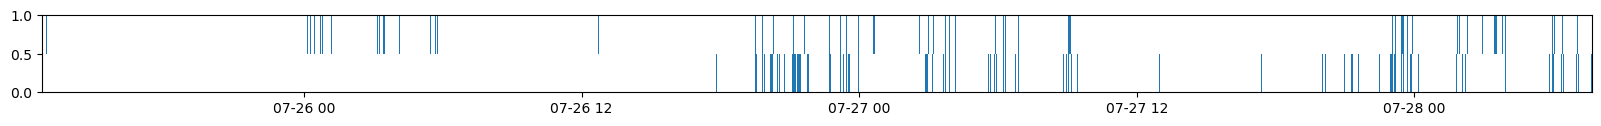

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(20,1))
ax.set_xlim([trial_starts.timestamp.min(), trial_starts.timestamp.max()])
ax.set_ylim([0, 1])

vid_points = [Rectangle((start, 0), duration, 0.5) for (start, duration) in vid_times]


trial_length = datetime.timedelta(seconds=2)
trial_points = [Rectangle((start, 0.5), trial_length, 0.5) for start in trial_starts.timestamp]

for r in vid_points:
    ax.add_patch(r)
for r in trial_points:
    ax.add_patch(r)


#### Average number of trials per video

In [108]:
# for vid in videos:
#    threshold trials to start of video to start + duration of video
#    count number of trials
#    frequency/ratio: divide by duration of video
#    compare across days
vidstats = pd.DataFrame(columns=["time", "num", "freq","duration"])
vidtrials = pd.DataFrame(columns=["vidstart", "vid_duration", "trial_start"])
for vid in vid_trials.iterrows():
    trials = animal_stats[(animal_stats.timestamp >= vid[1].start_time) & (animal_stats.timestamp <= vid[1].start_time + vid[1].duration)]
    count = trials["trial no"].unique().size
    t = vid[1].duration.seconds
    freq = count/(t)
    
    vidstats.loc[len(vidstats.index)] = (vid[1].start_time, count, freq, t)

In [109]:
vidstats.mean()

time        2023-07-27 10:41:35.985074432
num                              8.164179
freq                             0.098454
duration                        57.293532
dtype: object

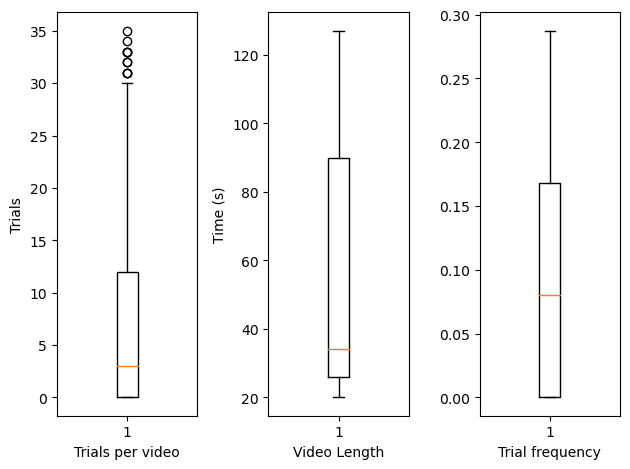

In [110]:
# distribution of length and number of trials per video

fig, axs = plt.subplots(1, 3)
axs[0].boxplot(vidstats.num)
axs[0].set_xlabel('Trials per video')
axs[0].set_ylabel('Trials')
axs[1].boxplot(vidstats.duration)
axs[1].set_xlabel('Video Length')
axs[1].set_ylabel('Time (s)')
axs[2].boxplot(vidstats.freq)
axs[2].set_xlabel('Trial frequency')
fig.tight_layout()

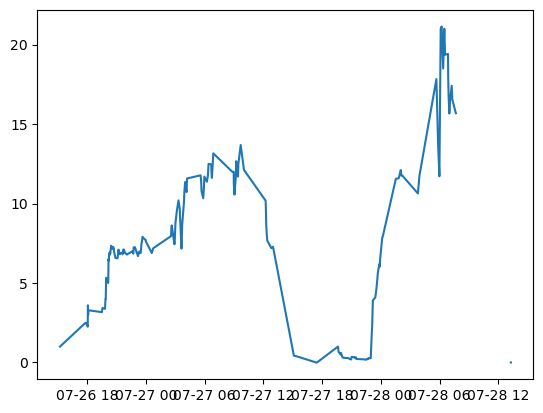

In [113]:
# 4h rolling average of number of trials/video
fig, axs = plt.subplots(1, 1)
vidstats = vidstats.sort_values("time")
roll = vidstats.rolling(pd.to_timedelta(4, unit="H"), on="time", closed="left").mean()
axs.plot(roll.time, roll.num)

### Inter bout interval

In [114]:
#inter trial interval and inter bout interval
vid_trials["end_time"] = vid_trials["start_time"] - vid_trials["duration"]
vid_trials["IBI"] = vid_trials["start_time"] - vid_trials["start_time"].shift()
vid_trials.mean()

start_time    2023-07-27 10:41:35.985074432
duration          0 days 00:00:57.748437810
end_time      2023-07-27 10:40:38.236637184
IBI                  0 days 00:13:50.115000
dtype: object

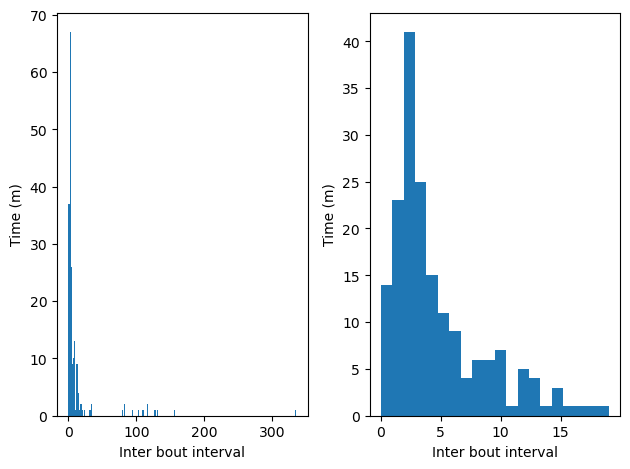

In [132]:
IBI_mins = vid_trials["IBI"].to_numpy(dtype='timedelta64[m]')[1:].astype(float)
IBI_excludesleep = vid_trials[vid_trials["IBI"] < pd.to_timedelta(20, unit="m")]["IBI"].to_numpy(dtype='timedelta64[m]')[1:].astype(float)

fig, axs = plt.subplots(1, 2)

axs[0].hist(IBI_mins, bins=200)
axs[0].set_xlabel('Inter bout interval')
axs[0].set_ylabel('Time (m)')
axs[1].hist(IBI_excludesleep, bins=20)
axs[1].set_xlabel('Inter bout interval')
axs[1].set_ylabel('Time (m)')

fig.tight_layout()

### Intrabout inter trial interval

In [156]:
vidtrials = pd.DataFrame()

for vid in vid_trials.iterrows():
    temp = pd.DataFrame()
    
    trials = trial_starts[(trial_starts.timestamp >= vid[1].start_time) & (trial_starts.timestamp <= vid[1].start_time + vid[1].duration)]

    temp["trial_start"] = trials.timestamp
    temp["vid_start"] = vid[1].start_time
    temp["vid_duration"] = vid[1].duration
    temp["ITI"] = trials.timestamp - trials.timestamp.shift()

    vidtrials = pd.concat([vidtrials, temp])

vidtrials = vidtrials[["vid_start", "vid_duration", "trial_start", "ITI"]]


,vid_start,vid_duration,trial_start,ITI
1420,2023-07-26 15:09:34,0 days 00:00:28.931000,2023-07-26 15:09:55.430000128,NaT
1421,2023-07-26 15:13:01,0 days 00:00:41.800000,2023-07-26 15:13:18.140000000,NaT
1422,2023-07-26 15:13:01,0 days 00:00:41.800000,2023-07-26 15:13:22.380000000,0 days 00:00:04.240000
1423,2023-07-26 15:13:01,0 days 00:00:41.800000,2023-07-26 15:13:26.100000000,0 days 00:00:03.720000
1424,2023-07-26 15:13:01,0 days 00:00:41.800000,2023-07-26 15:13:39.200000000,0 days 00:00:13.100000
...,...,...,...,...
4780,2023-07-28 07:04:16,0 days 00:01:55.686000,2023-07-28 07:05:58.880000000,0 days 00:00:03.489999872
4781,2023-07-28 07:04:16,0 days 00:01:55.686000,2023-07-28 07:06:02.910000128,0 days 00:00:04.030000128
4782,2023-07-28 07:13:46,0 days 00:00:26.668000,2023-07-28 07:13:59.190000128,NaT
4783,2023-07-28 07:13:46,0 days 00:00:26.668000,2023-07-28 07:14:01.940000000,0 days 00:00:02.749999872


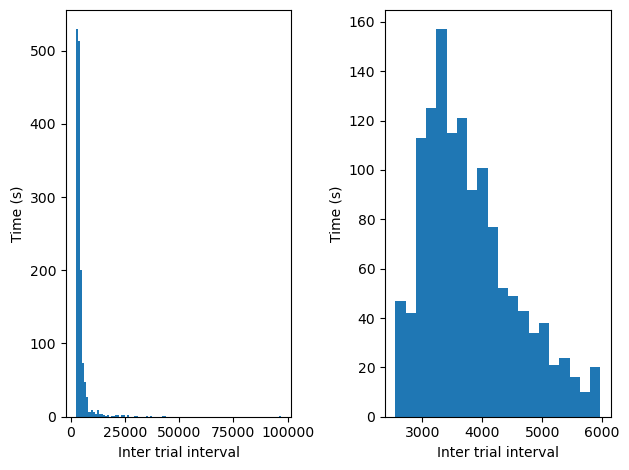

In [180]:
ITI_s = vidtrials["ITI"].dropna().to_numpy(dtype='timedelta64[ms]').astype(float)
ITI_short = vidtrials[vidtrials["ITI"] < pd.to_timedelta(6, unit="s")]["ITI"].to_numpy(dtype='timedelta64[ms]').astype(float)
fig, axs = plt.subplots(1, 2)

axs[0].hist(ITI_s, bins=100)
axs[0].set_xlabel('Inter trial interval')
axs[0].set_ylabel('Time (s)')
axs[1].hist(ITI_short, bins=20)
axs[1].set_xlabel('Inter trial interval')
axs[1].set_ylabel('Time (s)')

fig.tight_layout()